In [1]:
# Required libraries
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.models import inception_v3
from efficientnet_pytorch import EfficientNet
import umap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [2]:

stft_path = r'E:\1 Paper Work\Cutting Tool Paper\Dataset\cutting tool data\four_classes_term_cwt'  # Replace with the path to your STFT spectrograms
cwt_path = r'E:\1 Paper Work\Cutting Tool Paper\Dataset\cutting tool data\four_classes_term_cwt'    # Replace with the path to your CWT scalograms

# Function to load images and labels
def load_images_and_labels(data_path):
    images, labels = [], []
    for label_dir in os.listdir(data_path):
        label_path = os.path.join(data_path, label_dir)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                try:
                    img = Image.open(img_path).convert("RGB")  # Convert to RGB
                    images.append(img)
                    labels.append(label_dir)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    return images, labels

# Load data
stft_images, stft_labels = load_images_and_labels(stft_path)
cwt_images, cwt_labels = load_images_and_labels(cwt_path)

# Verify dataset sizes
print(f"Loaded {len(stft_images)} STFT images and {len(cwt_images)} CWT images.")


Loaded 160 STFT images and 160 CWT images.


In [3]:
# Preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to model input size
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Apply preprocessing to images
stft_images_preprocessed = torch.stack([preprocess(img) for img in stft_images])
cwt_images_preprocessed = torch.stack([preprocess(img) for img in cwt_images])

# Convert labels to numeric format
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

stft_labels_encoded = label_encoder.fit_transform(stft_labels)
cwt_labels_encoded = label_encoder.transform(cwt_labels)

# Verify preprocessing
print(f"STFT images shape: {stft_images_preprocessed.shape}")
print(f"CWT images shape: {cwt_images_preprocessed.shape}")
print(f"Encoded labels: {label_encoder.classes_}")


STFT images shape: torch.Size([160, 3, 224, 224])
CWT images shape: torch.Size([160, 3, 224, 224])
Encoded labels: ['BF' 'GF' 'N' 'TF']


In [4]:
# Load pretrained EfficientNet and InceptionV3 models
efficient_net = EfficientNet.from_pretrained('efficientnet-b0').to(device)
inception_net = inception_v3(pretrained=True).to(device)

# Remove classification layers
efficient_net._fc = torch.nn.Identity()  # Replace FC layer with identity
inception_net.fc = torch.nn.Identity()   # Replace FC layer with identity

# Set models to evaluation mode
efficient_net.eval()
inception_net.eval()

# Extract features function
def extract_features(model, images):
    features = []
    with torch.no_grad():
        for img in tqdm(images, desc=f"Extracting features using {model.__class__.__name__}"):
            img = img.unsqueeze(0).to(device)  # Add batch dimension
            feature = model(img).cpu().squeeze()  # Extract features
            features.append(feature)
    return torch.stack(features)

# Extract features for STFT (InceptionV3) and CWT (EfficientNet)
stft_features = extract_features(inception_net, stft_images_preprocessed)
cwt_features = extract_features(efficient_net, cwt_images_preprocessed)

# Verify shapes
print(f"STFT features shape: {stft_features.shape}")
print(f"CWT features shape: {cwt_features.shape}")


Loaded pretrained weights for efficientnet-b0


c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features using EfficientNet: 100%|██████████| 160/160 [00:05<00:00, 27.58it/s]

STFT features shape: torch.Size([160, 2048])
CWT features shape: torch.Size([160, 1280])


c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Combined features shape: torch.Size([160, 3328])


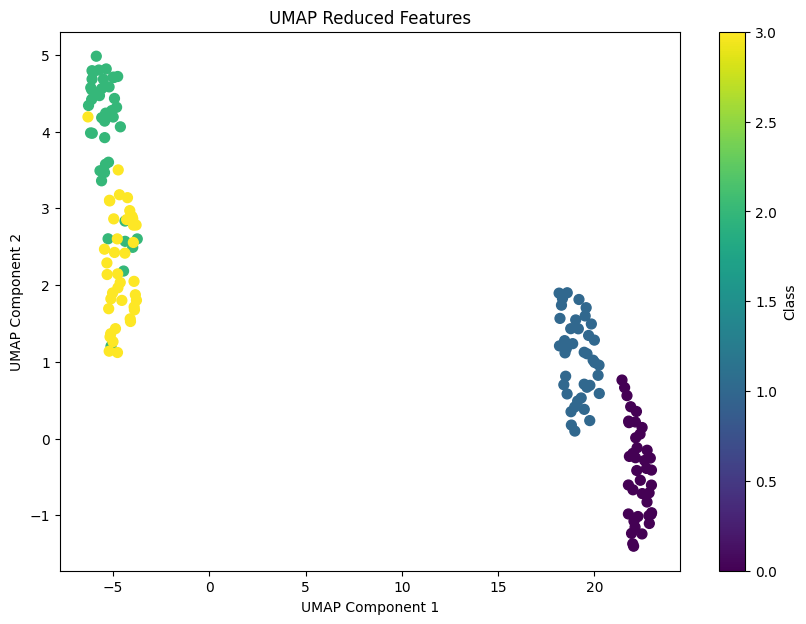

In [5]:
# Concatenate STFT and CWT features
combined_features = torch.cat((stft_features, cwt_features), dim=1)
print(f"Combined features shape: {combined_features.shape}")

# Perform UMAP dimensionality reduction
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_features = umap_reducer.fit_transform(combined_features.numpy())

# Visualize reduced features
plt.figure(figsize=(10, 7))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=stft_labels_encoded, cmap='viridis', s=50)
plt.colorbar(label="Class")
plt.title("UMAP Reduced Features")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    reduced_features, stft_labels_encoded, test_size=0.2, random_state=42
)

# Initialize and train k-NN classifier
knn = KNeighborsClassifier(n_neighbors=3)  # You can adjust the value of k
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Classification Report:
              precision    recall  f1-score   support

          BF       1.00      1.00      1.00        10
          GF       1.00      1.00      1.00         6
           N       0.80      0.89      0.84         9
          TF       0.83      0.71      0.77         7

    accuracy                           0.91        32
   macro avg       0.91      0.90      0.90        32
weighted avg       0.91      0.91      0.91        32

Confusion Matrix:
[[10  0  0  0]
 [ 0  6  0  0]
 [ 0  0  8  1]
 [ 0  0  2  5]]


In [7]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'n_neighbors': list(range(1, 11))}  # Test k values from 1 to 10

# Initialize the k-NN classifier
knn = KNeighborsClassifier()

# Use GridSearchCV to find the best k
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best k and corresponding accuracy
best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_

print(f"Best k: {best_k}")
print(f"Best cross-validated accuracy: {best_score:.2f}")

# Evaluate the best model on the test set
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

print("\nClassification Report with Tuned k:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Best k: 9
Best cross-validated accuracy: 0.95

Classification Report with Tuned k:
              precision    recall  f1-score   support

          BF       1.00      1.00      1.00        10
          GF       1.00      1.00      1.00         6
           N       0.89      0.89      0.89         9
          TF       0.86      0.86      0.86         7

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.94      0.94      0.94        32


Confusion Matrix:
[[10  0  0  0]
 [ 0  6  0  0]
 [ 0  0  8  1]
 [ 0  0  1  6]]


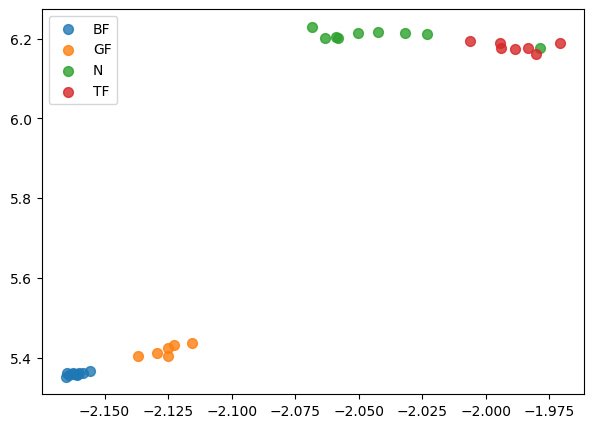

In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE on the test data
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_test_tsne = tsne.fit_transform(X_test)

# List of class names for your 4 classes
class_names = ["BF", "GF", "N", "TF"]

# Plotting the t-SNE for the test data
plt.figure(figsize=(7, 5))
for class_id, class_name in enumerate(class_names):
    idx = y_test == class_id  # Select points for the current class
    plt.scatter(
        X_test_tsne[idx, 0], 
        X_test_tsne[idx, 1], 
        label=class_name, 
        alpha=0.8, 
        s=50  # Adjust point size
    )

plt.legend()

plt.show()


In [9]:
# Train the k-NN classifier
knn.fit(X_train, y_train)


KNeighborsClassifier()

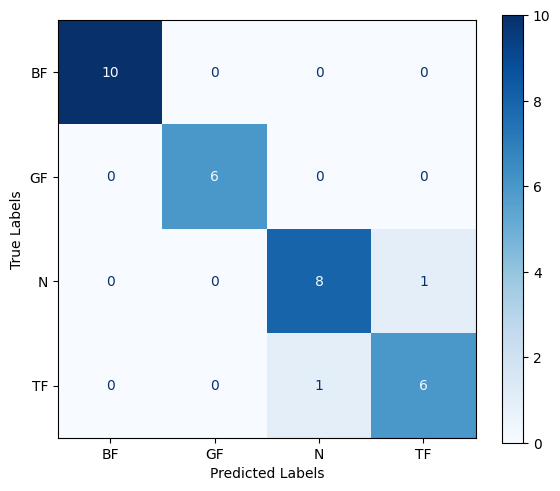

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = knn.predict(X_test)  # Replace 'knn' with your classifier if different

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Class names for the 4 classes
class_names = ["BF", "GF", "N", "TF"]

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

# Use a vibrant color map
disp.plot(cmap="Blues", values_format='d', ax=plt.gca())

# Title and axis labels
#plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Adjust layout to ensure labels fit well
plt.tight_layout()
plt.show()
